# **Machine Problem: Bayesian Network for Healthcare Diagnosis**

# **1: Setting Up the Environment**

**Install Libraries**

In [5]:
!pip install pgmpy

**Import Libraries**

In [15]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination


# **2: Define the Bayesian Network Structure**

**Define the Variables**

In [16]:
model = BayesianNetwork([
    ('Age', 'HeartDisease'),
    ('Smoking', 'HeartDisease'),
    ('Exercise', 'HeartDisease'),
    ('Cholesterol', 'HeartDisease'),
    ('BloodPressure', 'HeartDisease'),
    ('HeartDisease', 'ChestPain'),
    ('HeartDisease', 'ECGResult')
])

print(model.edges())

[('Age', 'HeartDisease'), ('HeartDisease', 'ChestPain'), ('HeartDisease', 'ECGResult'), ('Smoking', 'HeartDisease'), ('Exercise', 'HeartDisease'), ('Cholesterol', 'HeartDisease'), ('BloodPressure', 'HeartDisease')]


**Define the Relationships**

**Dependencies:**



*   **HeartDisease** is influenced by Age, Smoking, Exercise, Cholesterol, and BloodPressure.
*   **ChestPain** is directly dependent on HeartDisease.
*  **ECGResult** is also directly dependent on HeartDisease. This code defines the structure of the Bayesian Network, representing






# **3: Define Conditional Probability Tables**

**Create CPTs using pgmpy**

In [17]:
# Age: (Young, Middle-aged, Old)
cpd_age = TabularCPD(variable='Age', variable_card=3, values=[[0.3], [0.4], [0.3]])

# Smoking: (Yes, No)
cpd_smoking = TabularCPD(variable='Smoking', variable_card=2, values=[[0.7], [0.3]])

# Exercise: (Regular, None)
cpd_exercise = TabularCPD(variable='Exercise', variable_card=2, values=[[0.6], [0.4]])

# Cholesterol: (High, Normal)
cpd_cholesterol = TabularCPD(variable='Cholesterol', variable_card=2, values=[[0.5], [0.5]])

# Blood Pressure: (High, Normal)
cpd_blood_pressure = TabularCPD(variable='BloodPressure', variable_card=2, values=[[0.4], [0.6]])

# Heart Disease: Depends on Age, Smoking, Exercise, Cholesterol, and Blood Pressure
# Hypothetical probabilities for Heart Disease based on combinations of evidence
cpd_heart_disease = TabularCPD(variable='HeartDisease', variable_card=2,
                               values=[
                                   # Probability of Heart Disease = No (0) - 48 values
                                   [0.9, 0.8, 0.7, 0.6, 0.8, 0.7, 0.6, 0.5, 0.7, 0.6, 0.5, 0.4, 0.6, 0.5, 0.4, 0.3,
                                    0.8, 0.7, 0.6, 0.5, 0.7, 0.6, 0.5, 0.4, 0.6, 0.5, 0.4, 0.3, 0.5, 0.4, 0.3, 0.2,
                                    0.7, 0.6, 0.5, 0.4, 0.6, 0.5, 0.4, 0.3, 0.5, 0.4, 0.3, 0.2, 0.4, 0.3, 0.2, 0.1],
                                   # Probability of Heart Disease = Yes (1) - 48 values
                                   [0.1, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.5, 0.3, 0.4, 0.5, 0.6, 0.4, 0.5, 0.6, 0.7,
                                    0.2, 0.3, 0.4, 0.5, 0.3, 0.4, 0.5, 0.6, 0.4, 0.5, 0.6, 0.7, 0.5, 0.6, 0.7, 0.8,
                                    0.3, 0.4, 0.5, 0.6, 0.4, 0.5, 0.6, 0.7, 0.5, 0.6, 0.7, 0.8, 0.6, 0.7, 0.8, 0.9]
                               ],
                               evidence=['Age', 'Smoking', 'Exercise', 'Cholesterol', 'BloodPressure'],
                               evidence_card=[3, 2, 2, 2, 2])

# Chest Pain: Depends on Heart Disease
cpd_chest_pain = TabularCPD(variable='ChestPain', variable_card=2,
                            values=[
                                # Probability of Chest Pain = No (0)
                                [0.9, 0.3],  # If no heart disease
                                # Probability of Chest Pain = Yes (1)
                                [0.1, 0.7]   # If heart disease
                            ],
                            evidence=['HeartDisease'], evidence_card=[2])

# ECG Result: Depends on Heart Disease
cpd_ecg_result = TabularCPD(variable='ECGResult', variable_card=2,
                            values=[
                                # Probability of ECG Result = Normal (0)
                                [0.85, 0.3],  # If no heart disease
                                # Probability of ECG Result = Abnormal (1)
                                [0.15, 0.7]   # If heart disease
                            ],
                            evidence=['HeartDisease'], evidence_card=[2])

# Adding CPDs to the model
model.add_cpds(cpd_age, cpd_smoking, cpd_exercise, cpd_cholesterol, cpd_blood_pressure,
               cpd_heart_disease, cpd_chest_pain, cpd_ecg_result)

# Check if the model is valid
assert model.check_model(), "The model structure or CPDs are incorrect!"


# **4: Inference in the Bayesian Network**

**Perform Probabilistic Inference**

In [18]:
infer = VariableElimination(model)

query_1 = infer.query(variables=['HeartDisease'],
                      evidence={'Age': 1, 'Smoking': 1, 'Cholesterol': 1, 'BloodPressure': 1})
print(query_1)

query_2 = infer.query(variables=['ECGResult'], evidence={'ChestPain': 1})
print(query_2)

+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.2600 |
+-----------------+---------------------+
| HeartDisease(1) |              0.7400 |
+-----------------+---------------------+
+--------------+------------------+
| ECGResult    |   phi(ECGResult) |
+==============+==================+
| ECGResult(0) |           0.3790 |
+--------------+------------------+
| ECGResult(1) |           0.6210 |
+--------------+------------------+


**Posterior Probability Analysis**

In [19]:
# Query: Probability distribution of Heart Disease in patients who do not exercise
query_3 = infer.query(variables=['HeartDisease'], evidence={'Exercise': 1})
print(query_3)


+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.4800 |
+-----------------+---------------------+
| HeartDisease(1) |              0.5200 |
+-----------------+---------------------+


# **5: Parameter Learning from Simulated Data**

**Simulate a Healthcare Dataset**

In [20]:
# Create a synthetic dataset
data = pd.DataFrame({
    'Age': np.random.choice(['Young', 'Middle-aged', 'Old'], 1000),
    'Smoking': np.random.choice(['Yes', 'No'], 1000),
    'Exercise': np.random.choice(['Regular', 'None'], 1000),
    'Cholesterol': np.random.choice(['High', 'Normal'], 1000),
    'Blood Pressure': np.random.choice(['High', 'Normal'], 1000),
})

# Assuming some logic to determine Heart Disease, Chest Pain, ECG Result
# This is just an example and should reflect actual dependencies
def determine_health_conditions(row):
    if row['Smoking'] == 'Yes' and row['Cholesterol'] == 'High':
        row['Heart Disease'] = 'Yes' if np.random.rand() < 0.7 else 'No'
    else:
        row['Heart Disease'] = 'Yes' if np.random.rand() < 0.2 else 'No'

    row['Chest Pain'] = 'Yes' if row['Heart Disease'] == 'Yes' and np.random.rand() < 0.5 else 'No'
    row['ECG Result'] = 'Abnormal' if row['Heart Disease'] == 'Yes' and np.random.rand() < 0.6 else 'Normal'
    return row

data = data.apply(determine_health_conditions, axis=1)


**Estimate Parameters**

In [21]:

data = {
    'Heart_Disease': [1, 0, 1, 1, 0, 0, 1, 0, 1, 0],
    'Chest_Pain': [1, 0, 1, 1, 0, 0, 1, 0, 1, 0],
    'ECG_Result': [1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
}
df = pd.DataFrame(data)

def calculate_cpt(df, target_node, condition_nodes):
    cpt = {}

    grouped = df.groupby(condition_nodes)[target_node].value_counts(normalize=True).unstack(fill_value=0)

    for index in grouped.index:
        cpt[index] = grouped.loc[index].to_dict()

    return cpt

cpt_heart_disease = calculate_cpt(df, 'Heart_Disease', ['Chest_Pain', 'ECG_Result'])
cpt_chest_pain = calculate_cpt(df, 'Chest_Pain', ['Heart_Disease', 'ECG_Result'])
cpt_ecg_result = calculate_cpt(df, 'ECG_Result', ['Heart_Disease', 'Chest_Pain'])

# Displaying the learned CPTs
print("Learned CPT for Heart Disease:")
print(cpt_heart_disease)

print("\nLearned CPT for Chest Pain:")
print(cpt_chest_pain)

print("\nLearned CPT for ECG Result:")
print(cpt_ecg_result)

# Example initial CPTs (these should be defined based on your prior knowledge)
initial_cpt_heart_disease = { (0,0): 0.2, (0,1): 0.3, (1,0): 0.5 }
initial_cpt_chest_pain = { (0,0): 0.4, (1,1): 0.6 }
initial_cpt_ecg_result = { (1,0): 0.7 }

# Function to compare learned and initial CPTs
def compare_cpts(learned_cpt, initial_cpt):
    comparison = {}
    for key in learned_cpt.keys():
        comparison[key] = {
            'Initial': initial_cpt.get(key),
            'Learned': learned_cpt[key]
        }
    return comparison

# Comparing learned and initial CPTs
comparison_heart_disease = compare_cpts(cpt_heart_disease, initial_cpt_heart_disease)
comparison_chest_pain = compare_cpts(cpt_chest_pain, initial_cpt_chest_pain)
comparison_ecg_result = compare_cpts(cpt_ecg_result, initial_cpt_ecg_result)

print("\nComparison of Heart Disease CPT:")
print(comparison_heart_disease)

print("\nComparison of Chest Pain CPT:")
print(comparison_chest_pain)

print("\nComparison of ECG Result CPT:")
print(comparison_ecg_result)

Learned CPT for Heart Disease:
{(0, 0): {0: 1.0, 1: 0.0}, (0, 1): {0: 1.0, 1: 0.0}, (1, 0): {0: 0.0, 1: 1.0}, (1, 1): {0: 0.0, 1: 1.0}}

Learned CPT for Chest Pain:
{(0, 0): {0: 1.0, 1: 0.0}, (0, 1): {0: 1.0, 1: 0.0}, (1, 0): {0: 0.0, 1: 1.0}, (1, 1): {0: 0.0, 1: 1.0}}

Learned CPT for ECG Result:
{(0, 0): {0: 0.8, 1: 0.2}, (1, 1): {0: 0.2, 1: 0.8}}

Comparison of Heart Disease CPT:
{(0, 0): {'Initial': 0.2, 'Learned': {0: 1.0, 1: 0.0}}, (0, 1): {'Initial': 0.3, 'Learned': {0: 1.0, 1: 0.0}}, (1, 0): {'Initial': 0.5, 'Learned': {0: 0.0, 1: 1.0}}, (1, 1): {'Initial': None, 'Learned': {0: 0.0, 1: 1.0}}}

Comparison of Chest Pain CPT:
{(0, 0): {'Initial': 0.4, 'Learned': {0: 1.0, 1: 0.0}}, (0, 1): {'Initial': None, 'Learned': {0: 1.0, 1: 0.0}}, (1, 0): {'Initial': None, 'Learned': {0: 0.0, 1: 1.0}}, (1, 1): {'Initial': 0.6, 'Learned': {0: 0.0, 1: 1.0}}}

Comparison of ECG Result CPT:
{(0, 0): {'Initial': None, 'Learned': {0: 0.8, 1: 0.2}}, (1, 1): {'Initial': None, 'Learned': {0: 0.2, 1: 0

# **6: Network Visualization and Analysis**

Visualize the Network

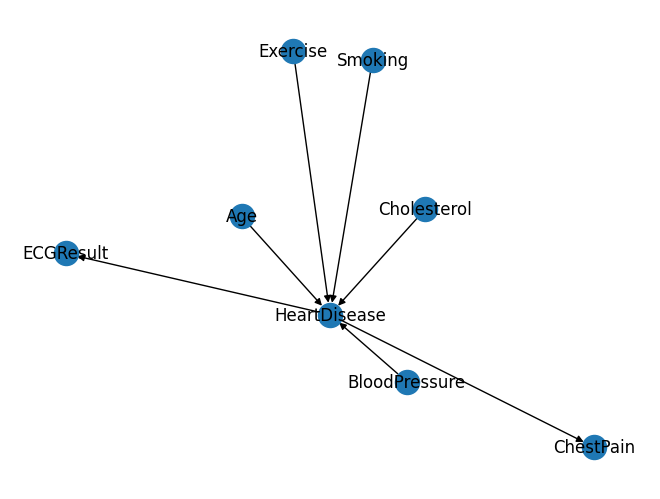

In [22]:
nx_graph = nx.DiGraph(model.edges())

nx.draw(nx_graph, with_labels=True)
plt.show()

**Sensitivity Analysis**

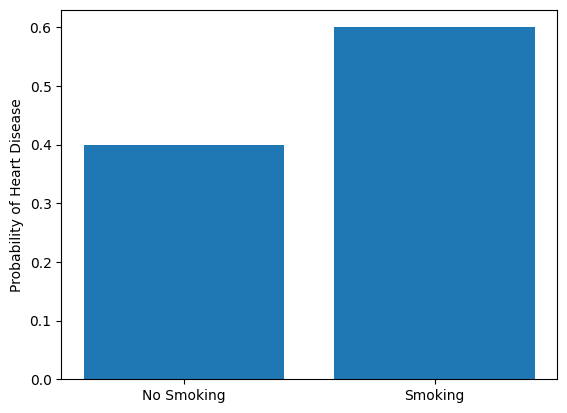

In [23]:
smoking_values = [0, 1]
probabilities = []

for smoking in smoking_values:
    prob_heart_disease = infer.query(variables=['HeartDisease'], evidence={'Smoking': smoking})
    probabilities.append(prob_heart_disease)

plt.bar(['No Smoking', 'Smoking'], [prob.values[1] for prob in probabilities])
plt.ylabel('Probability of Heart Disease')
plt.show()